In [ ]:
from google.colab import files
import io
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import plotly.express as px
import random
import matplotlib.pyplot as plt
import seaborn as sns

Upload file

In [ ]:
uploaded = files.upload()

Saving test.json to test.json
Saving train.json to train.json


In [ ]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']

In [ ]:
input_cols = ['sequence', 'structure', 'predicted_loop_type']

In [ ]:
train = pd.read_json(io.BytesIO(uploaded['train.json']), lines=True).drop('index', axis=1)
test = pd.read_json(io.BytesIO(uploaded['test.json']), lines=True).drop('index', axis=1)

In [ ]:
train = train.query("signal_to_noise >= 1")

In [ ]:
train = train.query("SN_filter == 1")

In [ ]:
test_private = test.query("seq_length == 130")

In [ ]:
test_public = test.query("seq_length == 107")

In [ ]:
train.head()

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


In [87]:
def preprocess_inputs(df,input_cols):
    """
    Converts inputs into one-hot
    """
    output = []
    for i in range(len(input_cols)):
        tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
        tokenizer.fit_on_texts(np.asarray(df[input_cols[i]]))
        tmp = tokenizer.texts_to_sequences(np.asarray(df[input_cols[i]]))
        new_var = np.asarray(keras.utils.to_categorical(tmp)[:,:,1:])
        if new_var.shape[1] != 130:
            longer = np.full((new_var.shape[0], 130, new_var.shape[2]), np.float32(0))
            for seq_index in range(len(new_var)):
                tmp = new_var[seq_index]
                row_len = len(tmp[0])
                new_line = np.full(row_len, -10, np.float32)
                while len(tmp) != 130:
                    tmp = np.vstack((tmp, new_line))
                longer[seq_index] = tmp
            output.append(longer)
        else:
            output.append(new_var)
    return output

In [ ]:
inputs = preprocess_inputs(train,input_cols)

In [ ]:
inputs[0][0][60:]

array([[  0.,   0.,   0.,   1.],
       [  1.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   1.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   1.],
       [  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   1.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.],
       [  1.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.],
       [  1.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  

In [ ]:
def merge_inputs(inputs):
    """
    Merges the one-hot inputs by columns
    Also snips seq length's till desired amount
    """
    size = len(inputs[0])
    output = []
    for i in range(size):
        output.append(np.concatenate((inputs[0][i], inputs[1][i], inputs[2][i]), axis = 1))
    return np.asarray(output)

In [ ]:
inputs_simple = merge_inputs(inputs)

In [91]:
inputs_public = merge_inputs(preprocess_inputs(test_public, input_cols))
inputs_private = merge_inputs(preprocess_inputs(test_private, input_cols))

In [93]:
inputs_private.shape

(3005, 130, 14)

In [ ]:
inputs_simple.shape

(1587, 130, 14)

In [119]:
def preprocess_results(df, results, train=True):
    """
    Makes sure that the results are in the appropriate format:
        [layers,lines,columns] in an np array
    """
    tmp = np.asarray(df[results])
    size = len(tmp[0])
    output = np.zeros((len(tmp),len(tmp[0][0]),len(results)))
    for i in range(len(results)):
        for j in range(size):
            tmp[i,j] = np.asarray(tmp[i,j])
    for i in range(len(tmp)):
        output[i] = np.vstack((tmp[i,0], tmp[i,1], tmp[i,2], 
                                tmp[i,3], tmp[i,4]))[:,:].T
    #if train == True:
    #    if output.shape[1] != 130:
    #        longer = np.full((output.shape[0], 130, output.shape[2]), np.float32(0))
    #        for seq_index in range(output.shape[0]):
    #            tmp = output[seq_index]
    #            row_len = len(tmp[0])
    #            new_line = np.full(row_len, -10, np.float32)
    #            while len(tmp) != 130:
    #                tmp = np.vstack((tmp, new_line))
    #            longer[seq_index] = tmp
    #    return longer
    #else:
    #    return output
    return output

In [120]:
expected_results = preprocess_results(train, pred_cols)

In [121]:
expected_results.shape

(1587, 68, 5)

In [60]:
def build_RNN(output_length, input_shape = (130,14), space_dropout = 0.2, lr=0.001, masking_val = np.float32(-10), 
              rnn_dropout = 0.3):
    masking_func = lambda inputs, previous_mask: previous_mask
    opt = tf.optimizers.Adam(learning_rate=lr)
    
    inputs = keras.layers.Input(shape=input_shape)
    mask = keras.layers.Masking(mask_value=np.float32(masking_val))(inputs)
    mask = keras.layers.SpatialDropout1D(space_dropout)(mask)
    
    features = keras.layers.Bidirectional(keras.layers.LSTM(100, activation='relu', return_sequences=True))(mask)

    sliced_features = features[:, :output_length]

    first_pred = keras.layers.Dense(1, activation='linear', name="reactivity")(sliced_features) #regression pour "reactivity"
    #first_out = keras.layers.Lambda(lambda first_pred: first_pred[:, :], mask=masking_func, name="reactivity")(first_pred)
    second_pred = keras.layers.Dense(1, activation='linear', name="deg_Mg_pH10")(sliced_features)  #regression pour "ph"
    #second_out = keras.layers.Lambda(lambda second_pred: second_pred[:, :], mask=masking_func, name="deg_Mg_pH10")(second_pred)
    third_pred = keras.layers.Dense(1, activation='linear', name="deg_Mg_50C")(sliced_features)
    #third_out = keras.layers.Lambda(lambda third_pred: third_pred[:, :], mask=masking_func, name="deg_Mg_50C")(third_pred)
    fourth_pred = keras.layers.Dense(1, activation='linear', name="deg_pH10")(sliced_features)
    #fourth_out = keras.layers.Lambda(lambda fourth_pred: fourth_pred[:, :], mask=masking_func, name="deg_pH10")(fourth_pred)
    fifth_pred = keras.layers.Dense(1, activation='linear', name="deg_50C")(sliced_features)
    #fifth_out = keras.layers.Lambda(lambda fifth_pred: fifth_pred[:, :], mask=masking_func, name="deg_50C")(fifth_pred)
    
    model = keras.Model(
        inputs=inputs,
        #outputs=[first_out, second_out, third_out, fourth_out, fifth_out],
        outputs=[first_pred, second_pred, third_pred, fourth_pred, fifth_pred],
    )
    model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])

    return model

In [69]:
training = build_RNN(68)
training.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 130, 14)]    0                                            
__________________________________________________________________________________________________
masking_14 (Masking)            (None, 130, 14)      0           input_15[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_7 (SpatialDro (None, 130, 14)      0           masking_14[0][0]                 
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 130, 200)     92000       spatial_dropout1d_7[0][0]        
______________________________________________________________________________________

In [70]:
lolo = training.fit(inputs_simple,
          [expected_results[:,:,0], expected_results[:,:,1], expected_results[:,:,2],
          expected_results[:,:,3], expected_results[:,:,4]], batch_size = 75, 
          epochs = 75, verbose = 1, validation_split = 0.2,
          callbacks = [keras.callbacks.ModelCheckpoint('trained.h5'), keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/75
17/17 [==============================] - 10s 566ms/step - loss: 1.5365 - reactivity_loss: 0.2411 - deg_Mg_pH10_loss: 0.3705 - deg_Mg_50C_loss: 0.3501 - deg_pH10_loss: 0.3808 - deg_50C_loss: 0.1940 - reactivity_root_mean_squared_error: 0.4910 - deg_Mg_pH10_root_mean_squared_error: 0.6087 - deg_Mg_50C_root_mean_squared_error: 0.5917 - deg_pH10_root_mean_squared_error: 0.6171 - deg_50C_root_mean_squared_error: 0.4405 - val_loss: 1.2177 - val_reactivity_loss: 0.2075 - val_deg_Mg_pH10_loss: 0.2841 - val_deg_Mg_50C_loss: 0.2375 - val_deg_pH10_loss: 0.3157 - val_deg_50C_loss: 0.1729 - val_reactivity_root_mean_squared_error: 0.4555 - val_deg_Mg_pH10_root_mean_squared_error: 0.5330 - val_deg_Mg_50C_root_mean_squared_error: 0.4874 - val_deg_pH10_root_mean_squared_error: 0.5618 - val_deg_50C_root_mean_squared_error: 0.4158
Epoch 2/75
17/17 [==============================] - 9s 551ms/step - loss: 1.1614 - reactivity_loss: 0.1928 - deg_Mg_pH10_loss: 0.2747 - deg_Mg_50C_loss: 0.2301 - deg

In [ ]:
#Creation of function that gives train and test set indexes from a pandas dataframe
def data_sep(dataset, data_size, train_size):
    train = random.sample(range(data_size), train_size)
    test = list(range(0,data_size))
    for i in train:
        test.remove(i)
    return(train,test)

In [122]:
inputs = inputs_simple
targets = expected_results
num_folds = 10
fold_no = 1
rmse_per_fold_reactivity = []
rmse_per_fold_deg_Mg_pH10 = []
rmse_per_fold_deg_Mg_50C = []
rmse_per_fold_deg_pH10 = []
rmse_per_fold_deg_50C = []
loss_per_fold_reactivity = []
loss_per_fold_deg_Mg_pH10 = []
loss_per_fold_deg_Mg_50C = []
loss_per_fold_deg_pH10 = []
loss_per_fold_deg_50C = []
while fold_no <= num_folds:
    kf_train_index,kf_test_index = data_sep(train,1587,1300)
    train_in = inputs[kf_train_index,]
    test_in = inputs[kf_test_index,]
    train_out = targets[kf_train_index,]
    test_out = targets[kf_test_index,]

    kf_model = build_RNN(68)
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = kf_model.fit(train_in, [train_out[:,:,0], train_out[:,:,1], train_out[:,:,2],
                        train_out[:,:,3], train_out[:,:,4]], batch_size=100, epochs=30, verbose=1)
    
    
    # Generate generalization metrics
    scores = kf_model.evaluate(test_in, [test_out[:,:,0], test_out[:,:,1], test_out[:,:,2],
                        test_out[:,:,3], test_out[:,:,4]], verbose=0)
    print(f'Score for fold {fold_no}: {kf_model.metrics_names[0]} of {scores[0]}; {kf_model.metrics_names[1]} of {scores[1]}; {kf_model.metrics_names[2]} of {scores[2]}; {kf_model.metrics_names[3]} of {scores[3]}; {kf_model.metrics_names[4]} of {scores[4]}; {kf_model.metrics_names[5]} of {scores[5]}')
    print(f'Score for fold {fold_no}: {kf_model.metrics_names[6]} of {scores[6]}; {kf_model.metrics_names[7]} of {scores[7]}; {kf_model.metrics_names[8]} of {scores[8]}; {kf_model.metrics_names[9]} of {scores[9]}; {kf_model.metrics_names[10]} of {scores[10]};')
    rmse_per_fold_reactivity.append(scores[6])
    rmse_per_fold_deg_Mg_pH10.append(scores[7])
    rmse_per_fold_deg_Mg_50C.append(scores[8])
    rmse_per_fold_deg_pH10.append(scores[9])
    rmse_per_fold_deg_50C.append(scores[10])
    loss_per_fold_reactivity.append(scores[1])
    loss_per_fold_deg_Mg_pH10.append(scores[2])
    loss_per_fold_deg_Mg_50C.append(scores[3])
    loss_per_fold_deg_pH10.append(scores[4])
    loss_per_fold_deg_50C.append(scores[5])
    
    fold_no+=1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
13/13 [==============================] - 3s 199ms/step - loss: 1.5125 - reactivity_loss: 0.2645 - deg_Mg_pH10_loss: 0.3303 - deg_Mg_50C_loss: 0.2882 - deg_pH10_loss: 0.3945 - deg_50C_loss: 0.2350 - reactivity_root_mean_squared_error: 0.5143 - deg_Mg_pH10_root_mean_squared_error: 0.5748 - deg_Mg_50C_root_mean_squared_error: 0.5369 - deg_pH10_root_mean_squared_error: 0.6281 - deg_50C_root_mean_squared_error: 0.4847
Epoch 2/30
13/13 [==============================] - 3s 203ms/step - loss: 1.1872 - reactivity_loss: 0.2015 - deg_Mg_pH10_loss: 0.2674 - deg_Mg_50C_loss: 0.2226 - deg_pH10_loss: 0.3127 - deg_50C_loss: 0.1830 - reactivity_root_mean_squared_error: 0.4489 - deg_Mg_pH10_root_mean_squared_error: 0.5171 - deg_Mg_50C_root_mean_squared_error: 0.4718 - deg_pH10_root_mean_squared_error: 0.5592 - deg_50C_root_mean_squared_error: 0.4278
Epoch 3/30
13/13 [=============================

In [123]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(loss_per_fold_reactivity)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}')
    print(f'Reactivity:  Loss = {loss_per_fold_reactivity[i]}, RMSE = {rmse_per_fold_reactivity[i]}')
    print(f'Deg_Mg_pH10:  Loss = {loss_per_fold_deg_Mg_pH10[i]}, RMSE = {rmse_per_fold_deg_Mg_pH10[i]}')
    print(f'Deg_Mg_50C:  Loss = {loss_per_fold_deg_Mg_50C[i]}, RMSE = {rmse_per_fold_deg_Mg_50C[i]}')
    print(f'Deg_pH10:  Loss = {loss_per_fold_deg_pH10[i]}, RMSE = {rmse_per_fold_deg_pH10[i]}')
    print(f'Deg_50C:  Loss = {loss_per_fold_deg_50C[i]}, RMSE = {rmse_per_fold_deg_50C[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Reactivity RMSE: {np.mean(rmse_per_fold_reactivity)} (+- {np.std(rmse_per_fold_reactivity)})')
print(f'> Deg_Mg_pH10 RMSE: {np.mean(rmse_per_fold_deg_Mg_pH10)} (+- {np.std(rmse_per_fold_deg_Mg_pH10)})')
print(f'> Deg_Mg_50C RMSE: {np.mean(rmse_per_fold_deg_Mg_50C)} (+- {np.std(rmse_per_fold_deg_Mg_50C)})')
print(f'> Deg_pH10 RMSE: {np.mean(rmse_per_fold_deg_pH10)} (+- {np.std(rmse_per_fold_deg_pH10)})')
print(f'> Deg_50C RMSE: {np.mean(rmse_per_fold_deg_50C)} (+- {np.std(rmse_per_fold_deg_50C)})')
print(f'> Reactivity loss: {np.mean(loss_per_fold_reactivity)} (+- {np.std(loss_per_fold_reactivity)})')
print(f'> Deg_Mg_pH10 loss: {np.mean(loss_per_fold_deg_Mg_pH10)} (+- {np.std(loss_per_fold_deg_Mg_pH10)})')
print(f'> Deg_Mg_50C loss: {np.mean(loss_per_fold_deg_Mg_50C)} (+- {np.std(loss_per_fold_deg_Mg_50C)})')
print(f'> Deg_pH10 loss: {np.mean(loss_per_fold_deg_pH10)} (+- {np.std(loss_per_fold_deg_pH10)})')
print(f'> Deg_50C loss: {np.mean(loss_per_fold_deg_50C)} (+- {np.std(loss_per_fold_deg_50C)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1
Reactivity:  Loss = 0.09499772638082504, RMSE = 0.30821701884269714
Deg_Mg_pH10:  Loss = 0.14636830985546112, RMSE = 0.38258108496665955
Deg_Mg_50C:  Loss = 0.1151924803853035, RMSE = 0.33940017223358154
Deg_pH10:  Loss = 0.12309154868125916, RMSE = 0.35084405541419983
Deg_50C:  Loss = 0.09329096227884293, RMSE = 0.3054356873035431
------------------------------------------------------------------------
> Fold 2
Reactivity:  Loss = 0.09916899353265762, RMSE = 0.3149110972881317
Deg_Mg_pH10:  Loss = 0.15256845951080322, RMSE = 0.3906001150608063
Deg_Mg_50C:  Loss = 0.11824598163366318, RMSE = 0.343869149684906
Deg_pH10:  Loss = 0.12448467314243317, RMSE = 0.3528238534927368
Deg_50C:  Loss = 0.08862480521202087, RMSE = 0.2976991832256317
------------------------------------------------------------------------
> Fold 3
Re

In [71]:
model_train_pred = build_RNN(107)
model_train_pred.load_weights('trained.h5')

In [96]:
model_public = build_RNN(107)
model_public.load_weights('trained.h5')

In [97]:
model_private = build_RNN(130)
model_private.load_weights('trained.h5')

In [72]:
train_full_predicted = model_train_pred.predict(inputs_simple)

In [98]:
public_full_predicted = model_public.predict(inputs_public)

In [99]:
private_full_predicted = model_private.predict(inputs_private)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



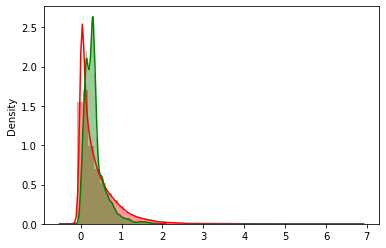

In [113]:
sns.distplot(expected_results[:,:,0], color='red')
sns.distplot(train_full_predicted[0], color='green')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



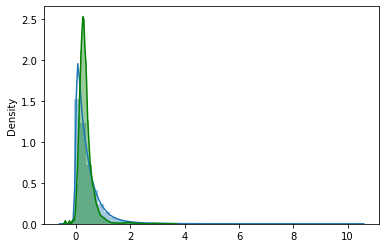

In [114]:
sns.distplot(expected_results[:,:,:])
sns.distplot(train_full_predicted, color='green')
plt.show()

In [85]:
fig = px.line(lolo.history, y = ['loss', 'val_loss'], labels={'index':'epoch', 'value':keras.metrics.RootMeanSquaredError()},title='Training History')
fig.show()

**Revoir donnees a predire**

Prendre en compte bpps (mat 2d), fournir a dense (1 branche seq 1d, 1 branche bpps 2d, concatene a la fin)